In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error

In [ ]:
# 1. Loading and Inspecting the Data
data = pd.read_csv('/content/ethereum_daily_data_2018_2024.csv')

# Convert 'time' to datetime format
data['time'] = pd.to_datetime(data['time'])

# Set 'time' as index
data.set_index('time', inplace=True)



In [ ]:
# Compute daily percentage change
data['Daily_Change'] = data['Close'].pct_change() * 100
data.dropna(inplace=True)

# Compute thresholds
mean_drop = data['Daily_Change'][data['Daily_Change'] < 0].mean()
std_dev = data['Daily_Change'][data['Daily_Change'] < 0].std()
threshold_alert = abs(mean_drop) + (1 * std_dev)

threshold_trend = abs(mean_drop) + (0.3 * std_dev)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Creating a function to split the data into sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

# Define the sequence length (e.g., 60 days)
sequence_length = 60

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create training sequences and labels
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [ ]:
model = Sequential()

# First LSTM layer with Dropout regularization
model.add(Input(shape=(X_train.shape[1], 1)))  # Defining the input shape explicitly
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense layers for output
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model (70 epochs, batch size of 84)
history = model.fit(X_train, y_train, epochs=70, batch_size=84, validation_data=(X_test, y_test))

Epoch 1/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0387 - val_loss: 0.0019
Epoch 2/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 3/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 4/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 5/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 6/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 7/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 8/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 9/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 10/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 11/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 12/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.

In [ ]:
predictions = model.predict(X_test)

# Inverse scaling the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

# Inverse scaling the actual test values
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(y_test_scaled, predictions)
print(f"Mean Squared Error: {mse}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Squared Error: 12348.862856937589


In [ ]:
last_60_days = data['Close'][-sequence_length:].values.reshape(-1, 1)

# Scale the last 60 days data
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to hold the scaled sequence
X_predict = []
X_predict.append(last_60_days_scaled)

# Convert the list to a numpy array and reshape for LSTM input
X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

# Predict the future price
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Ethereum Price: {predicted_price[0][0]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Ethereum Price: 2608.257568359375


In [ ]:
latest_change = (predicted_price[0][0] - data['Close'].iloc[-1]) / data['Close'].iloc[-1] * 100
if latest_change <= -threshold_alert:
    print("🚨 ALERT! Significant drop detected! Market is highly bearish! 🚨")
elif latest_change <= -threshold_trend:
    print("⚠️ Warning: Bearish trend detected!")
elif latest_change >= threshold_trend:
    print("✅ Bullish trend detected!")
else:
    print("📈 Market is stable.")

📈 Market is stable.


In [ ]:
results_df = pd.DataFrame({
    'Metric': ['Total Data Points', 'Training Data Points', 'Testing Data Points',
               'Mean Squared Error (MSE)', 'First Actual Price', 'First Predicted Price',
               'Last Actual Price', 'Last Predicted Price', 'Predicted Future Price'],
    'Value': [len(data), len(X_train), len(X_test),
              mse, y_test_scaled[0][0], predictions[0][0],
              y_test_scaled[-1][0], predictions[-1][0], predicted_price[0][0]]
})

# Markdown
print(results_df.to_markdown())

|    | Metric                   |    Value |
|---:|:-------------------------|---------:|
|  0 | Total Data Points        |  2461    |
|  1 | Training Data Points     |  1908    |
|  2 | Testing Data Points      |   433    |
|  3 | Mean Squared Error (MSE) | 12348.9  |
|  4 | First Actual Price       |  1866.58 |
|  5 | First Predicted Price    |  1876.67 |
|  6 | Last Actual Price        |  2636.51 |
|  7 | Last Predicted Price     |  2616.03 |
|  8 | Predicted Future Price   |  2608.26 |


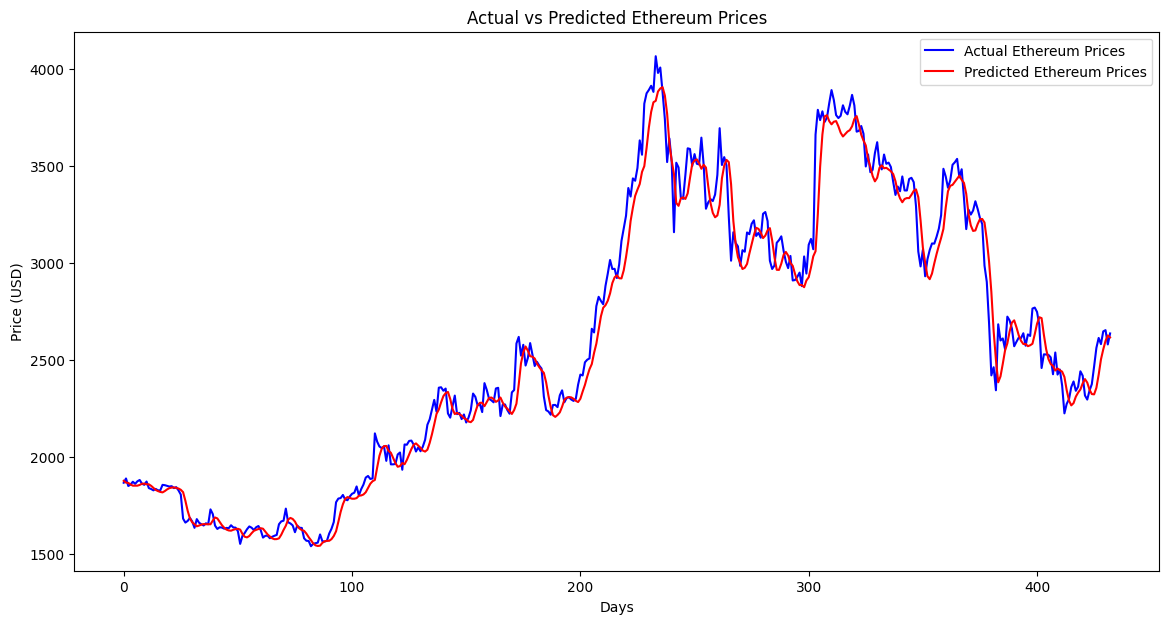

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Ethereum Prices', color='blue')
plt.plot(predictions, label='Predicted Ethereum Prices', color='red')
plt.title('Actual vs Predicted Ethereum Prices')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()


plt.show()

In [ ]:
future_days = 60

# Get the last 60 days of data for starting the predictions
last_60_days = data['Close'][-sequence_length:].values.reshape(-1, 1)
last_60_days_scaled = scaler.transform(last_60_days)

# List to store the predicted future prices
future_predictions = []

# Loop to predict the next 60 days
for i in range(future_days):
    # Create a new sequence from the last 60 days
    X_predict = []
    X_predict.append(last_60_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    # Store the predicted price
    future_predictions.append(predicted_price_unscaled[0, 0])

    # Update the sequence to include the predicted price
    new_scaled_data = np.append(last_60_days_scaled[1:], predicted_price, axis=0)
    last_60_days_scaled = new_scaled_data.reshape(-1, 1)

# َAdd to plott

future_dates = pd.date_range(start=data.index[-1], periods=future_days+1, freq='D')[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

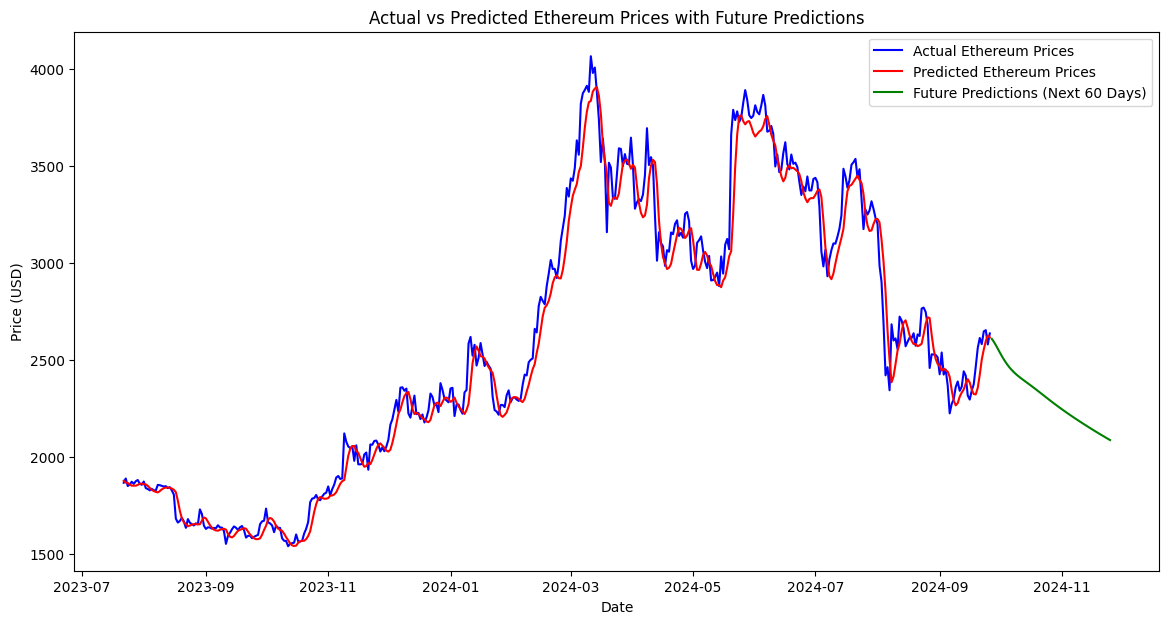

In [ ]:
plt.figure(figsize=(14, 7))

# actual prices
plt.plot(data.index[-len(y_test_scaled):], y_test_scaled, label='Actual Ethereum Prices', color='blue')

# predictions price
plt.plot(data.index[-len(y_test_scaled):], predictions, label='Predicted Ethereum Prices', color='red')

# Future Predictions (Next 60 Days)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 60 Days)', color='green')

# Plotting
plt.title('Actual vs Predicted Ethereum Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
model.save('ethereum_lstm_model.h5')